In [1]:
import seaborn as sns
import pandas as pd
import pyodbc as odbc 

query="""SELECT sd.[iGarbageBinId]
       ,max(sd.[nCurrentVolumePerc]) maxVal
       ,sd.[dtReceiveData] 
       ,g.iNeighborhoodId
FROM  TStation s
----השידור האחרון לפני ריקון#
cross apply(select top 1 sd.* from TSensorData sd
             where  s.iGarbageBinId=sd.iGarbageBinId  and sd.dtCreateDate<=s.dtStationStatusDate
             order by sd.dtCreateDate desc)sd
join TRoute r
on s.iRouteId=r.iRouteId
join TGarbageBin g
on g.iGarbageBinId=s.iGarbageBinId
where [dtReceiveData]>='2020-01-01' 
group by sd.[iGarbageBinId]
         ,sd.[dtReceiveData]
         ,g.iNeighborhoodId
having    max(sd.[nCurrentVolumePerc]) < 75 or max(sd.[nCurrentVolumePerc]) >90      
order by sd.iGarbageBinId ,sd.dtReceiveData asc"""
conn=odbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-0KEV1HG\SQLEXPRESS;'
                      'Database=CleanJerusalem;'
                      'Trusted_Connection=yes;')
df=pd.read_sql(query, conn)
df.head()


,iGarbageBinId,maxVal,dtReceiveData,iNeighborhoodId
0,10,69.548387,2020-07-07 23:01:03.913,152
1,10,74.645161,2020-07-09 05:28:44.757,152
2,10,67.483871,2020-07-14 04:12:19.913,152
3,10,67.612903,2020-07-24 04:41:40.413,152
4,10,91.000000,2020-07-26 02:14:45.170,152


In [2]:
#sns.pairplot(df,hue='dtReceiveData')

In [3]:
df["weekday"]= df.dtReceiveData.dt.weekday
df["week"] =  df["dtReceiveData"].dt.week
df["dtReceiveDataInt"]= df.dtReceiveData.dt.year*10000+ df.dtReceiveData.dt.month*100+ df.dtReceiveData.dt.day
df["dtReceiveData"]= df.dtReceiveData.dt.date


In [4]:
df.head()

,iGarbageBinId,maxVal,dtReceiveData,iNeighborhoodId,weekday,week,dtReceiveDataInt
0,10,69.548387,2020-07-07,152,1,28,20200707
1,10,74.645161,2020-07-09,152,3,28,20200709
2,10,67.483871,2020-07-14,152,1,29,20200714
3,10,67.612903,2020-07-24,152,4,30,20200724
4,10,91.000000,2020-07-26,152,6,30,20200726


In [5]:
import sklearn.preprocessing as sp
s = sp.StandardScaler()
df1=df.drop('dtReceiveData',axis=1)
scaled_features=s.fit_transform(df1.drop('maxVal',axis=1))

In [6]:
df_feat = pd.DataFrame(scaled_features,columns=df1.drop('maxVal',axis=1).columns)
df_feat.head()

,iGarbageBinId,iNeighborhoodId,weekday,week,dtReceiveDataInt
0,-1.876483,0.672064,-0.977534,-0.637721,-0.453198
1,-1.876483,0.672064,0.110499,-0.637721,-0.452513
2,-1.876483,0.672064,-0.977534,-0.565693,-0.450801
3,-1.876483,0.672064,0.654516,-0.493666,-0.447377
4,-1.876483,0.672064,1.742549,-0.493666,-0.446693


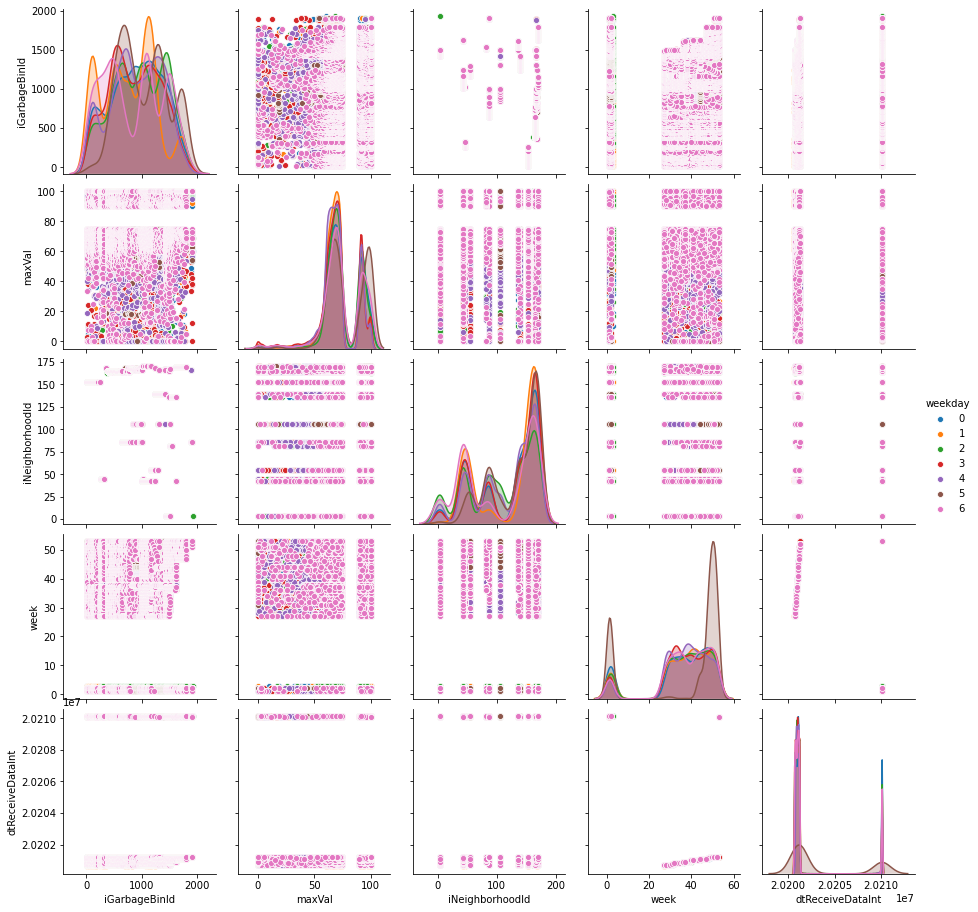

In [7]:
sns.pairplot(df,hue='weekday')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50557 entries, 0 to 50556
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iGarbageBinId     50557 non-null  int64  
 1   maxVal            50557 non-null  float64
 2   dtReceiveData     50557 non-null  object 
 3   iNeighborhoodId   50557 non-null  int64  
 4   weekday           50557 non-null  int64  
 5   week              50557 non-null  int64  
 6   dtReceiveDataInt  50557 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.7+ MB


In [9]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(scaled_features,df["maxVal"],test_size=0.3)
X=df1.drop('maxVal',axis=1)
y=df["maxVal"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
import sklearn.linear_model as sklin
import sklearn.tree as sktree
import sklearn.svm as sksvm
import sklearn.naive_bayes as sknb
import sklearn.neighbors as skknn
import sklearn.neural_network as sknn
import sklearn.ensemble as sken
#model = sklin.LinearRegression()
model = sktree.DecisionTreeRegressor()
#model = sksvm.SVR()
#model = skknn.KNeighborsRegressor()
#model = sknn.MLPRegressor()
#model = sken.RandomForestRegressor()
model.fit(X_train,y_train)
model.score(X_test,y_test)

-0.5477594123346063